In [1]:
import pandas as pd

In [ ]:
df = pd.read_csv('./data/second_innings.csv')
df

In [ ]:
df.drop(columns=['venue', 'innings', 'ball', 'batting_team', 'bowling_team', 'runs_off_bat', 'extras', 'wides', 'noballs', 'byes', 'legbyes', 'wicket_type'], inplace=True)
df.head()

In [ ]:
df.isna().sum()

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.isna().sum()

In [ ]:
df.shape

In [ ]:
df['runs_required'] = df['runs_required'].astype('int')
df['wickets_remaining'] = df['wickets_remaining'].astype('int')
df['balls_remaining'] = df['balls_remaining'].astype('int')
df['winner'] = df['winner'].astype('int')

In [ ]:
df.head()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fast')

In [ ]:
# scatter plot for runs required with minimum runs 100 vs balls remaining
plt.figure(figsize=(10, 6))
sns.scatterplot(x='balls_remaining', y='runs_required', data=df[(df['runs_required'] > 100)], alpha=0.6)
plt.title('Runs Required vs Balls Remaining')
plt.xlabel('Balls Remaining')
plt.ylabel('Runs Required')
plt.show()

In [ ]:
# boxplot for runs remaining with more than 119 balls remaining
plt.figure(figsize=(10, 6))
sns.boxplot(y='runs_required', data=df[(df['balls_remaining'] >= 119)])
plt.title('Runs Required with more than 119 balls remaining')
plt.show()

In [ ]:
# get q1, q2, q3 for runs remaining with more than 119 balls remaining
q1 = df[(df['balls_remaining'] >= 119)]['runs_required'].quantile(0.25)
q2 = df[(df['balls_remaining'] >= 119)]['runs_required'].quantile(0.5)
q3 = df[(df['balls_remaining'] >= 119)]['runs_required'].quantile(0.75)

print(f'Q1: {q1}, Q2: {q2}, Q3: {q3}')

iqr = q3 - q1

# get lower and upper bounds
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

print(f'Lower Bound: {lower_bound}, Upper Bound: {upper_bound}')

In [ ]:
# find match_id for outliers accordingly
outliers = df[(df['balls_remaining'] >= 119)][(df['runs_required'] < lower_bound) | (df['runs_required'] > upper_bound)]

outlier_matches = outliers['match_id'].unique()

outlier_matches

In [ ]:
df[df['match_id'].isin(outlier_matches)]

In [ ]:
# drop where match id is in outlier_matches
df = df[~df['match_id'].isin(outlier_matches)]
df

In [ ]:
# preprocessing for model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X = df[['runs_required', 'wickets_remaining', 'crr', 'rrr', 'balls_remaining']]
# X = df[['runs_required', 'wickets_remaining', 'balls_remaining']]
y = df['winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# logistic regression model
from sklearn.linear_model import LogisticRegression
# from sklearn.pipeline import Pipeline

# pipe = Pipeline(steps=[('scaler', trf), ('model', LogisticRegression())])

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [ ]:
accuracy = model.score(X_test, y_test)
accuracy

In [ ]:
print(X_test[10])
model.predict_proba(X_test)[10]

In [ ]:
# test for custom input
# custom_data = [70, 8, 6, 8.4, 50]
custom_data = [2, 1, 10, 2.4, 5]

# scale custom data
custom_data = scaler.transform([custom_data])

print(model.predict(custom_data))
print(model.predict_proba(custom_data))

In [171]:
test_data = [[100, 5, 10, 10, 100]]
test_data = scaler.transform(test_data)

test_data

array([[ 0.00970166, -0.95520569,  1.1486712 , -0.12962796,  1.05510354]])

In [172]:
# load the scaler
scaler = joblib.load('./models/scaler.pkl')

# test on custom data
test_data = [[100, 5, 10, 10, 100]]
test_data = scaler.transform(test_data)

test_data

array([[ 0.00970166, -0.95520569,  1.1486712 , -0.12962796,  1.05510354]])

### Test model over ranges of overs

In [188]:
# make a function for above 5 cells
def get_accuracy(model, data):
    X = data[['runs_required', 'wickets_remaining', 'crr', 'rrr', 'balls_remaining']]
    y = data['winner']

    X = scaler.transform(X)

    accuracy = model.score(X, y)
    return accuracy

def test_over_overs(model):
    first_5_overs = df[(df['balls_remaining'] >= 90)].copy()
    overs_5_10 = df[(df['balls_remaining'] >= 60) & (df['balls_remaining'] < 90)].copy()
    overs_10_15 = df[(df['balls_remaining'] >= 30) & (df['balls_remaining'] < 60)].copy()
    overs_15_20 = df[(df['balls_remaining'] < 30)].copy()

    first_5_overs_accuracy = get_accuracy(model, first_5_overs)
    overs_5_10_accuracy = get_accuracy(model, overs_5_10)
    overs_10_15_accuracy = get_accuracy(model, overs_10_15)
    overs_15_20_accuracy = get_accuracy(model, overs_15_20)

    return first_5_overs_accuracy, overs_5_10_accuracy, overs_10_15_accuracy, overs_15_20_accuracy

In [192]:
acc_0_5, acc_5_10, acc_10_15, acc_15_20 = test_over_overs(lr_model)

print(f'First 5 Overs Accuracy: {acc_0_5}')
print(f'5-10 Overs Accuracy: {acc_5_10}')
print(f'10-15 Overs Accuracy: {acc_10_15}')
print(f'15-20 Overs Accuracy: {acc_15_20}')

First 5 Overs Accuracy: 0.757309897060836
5-10 Overs Accuracy: 0.8127932040065932
10-15 Overs Accuracy: 0.8536585365853658
15-20 Overs Accuracy: 0.8663911504862778


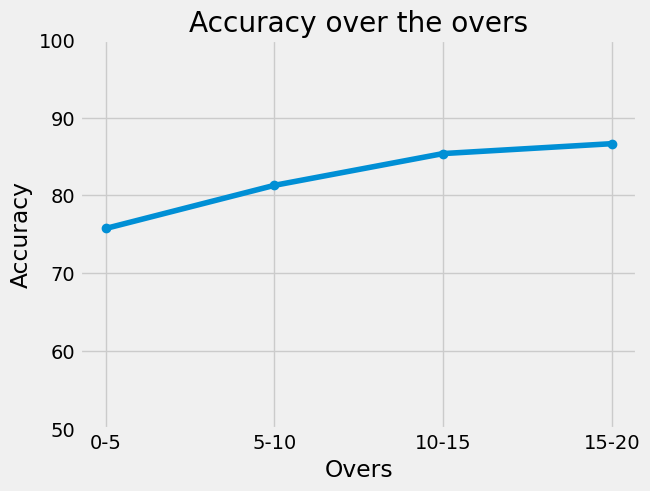

In [196]:
x = ['0-5', '5-10', '10-15', '15-20']
y = [acc_0_5 * 100, acc_5_10 * 100, acc_10_15 * 100, acc_15_20 * 100]

plt.plot(x, y, marker='o')
plt.ylim(50, 100)
plt.title('Accuracy over the overs')
plt.xlabel('Overs')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)

In [ ]:
rf_classifier.score(X_test, y_test)

## Feedforward Neural Network with 1 hidden layer

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2

In [ ]:
# predict
y_pred = fnn_1l_model.predict(X_test)

loss, accuracy = fnn_1l_model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

In [ ]:
# test for custom input
# custom_data = [10, 5, 60, 1]
custom_data = [70, 8, 6, 8.4, 50]

# scale custom data
custom_data = scaler.transform([custom_data])

batting_team_probability = fnn_1l_model.predict(custom_data)[0][0]
bowling_team_probability = 1 - batting_team_probability

print(f'Batting Team Probability: {batting_team_probability}')
print(f'Bowling Team Probability: {bowling_team_probability}')

In [ ]:
fnn_2l_model = Sequential()

fnn_2l_model.add(Dense(4, activation='tanh'))
fnn_2l_model.add(Dense(64, activation='tanh'))
fnn_2l_model.add(Dense(32, activation='tanh'))
fnn_2l_model.add(Dense(1, activation='sigmoid'))

fnn_2l_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

fnn_2l_model.fit(X_train, y_train, epochs=10, verbose=1)

In [ ]:
# predict
y_pred = fnn_2l_model.predict(X_test)

loss, accuracy = fnn_2l_model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')